# **Linear Regression Models**

Laboratory 3 of the Machine Learning class by Prof. F. Chiariotti at University of Padova during academic year 2024-2025

In [1]:
# importing all the necessary python libraries

import numpy as np
import pandas as pd
import random as rnd
from matplotlib import pyplot as plt
from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split

# **VR traffic prediction**

The data come from the paper:

> Lecci, Mattia, _et al._ "An open framework for analyzing and modeling XR network traffic." IEEE Access 9 (2021): 129782-129795.

The VR game Virus Popper was instantiated on a computer through the RiftCat application: the user could then see the virtual content on their phone, which was strapped to their head with a Cardboard viewer. The game was run at 60 frames per second, with a target rate of 30 Mb/s. 

The file ``virus_popper.csv`` contains three columns from the traffic capture:

idx    | frame size (B) |  time (s) 
0      | 38424          |  0.0
1      | 39801          |  0.01944


The task is then to predict the size of the next frame, given the past N frames. So, we are learning a time series: let us consider a memory of 2 samples, i.e., use X[n-1] and X[n-2] to predict X[n]. This was explored in another paper:

> Chiariotti, Federico, _et al._ "Temporal characterization and prediction of vr traffic: A network slicing use case." IEEE Transactions on Mobile Computing 23.5 (2023): 3890-3908.


In [2]:
np.random.seed(1) # setting the seed

def load_dataset(filename):
    # function that loads the csv file and returns the second column (frame size)
    data_train = pd.read_csv(filename)
    data = data_train.iloc[:, 1].values 
    return data

data = load_dataset('data/virus_popper.csv') # loading the dataset

In [3]:
# preparing the data and splitting it between training and test set

avg_size = np.mean(data)
norm_data = np.asarray(data) / avg_size # normalizing the dataset

m_training = int(0.75*norm_data.shape[0]) # computing the split

# preparing the columns and splitting for both
X_training = np.ones([m_training - 2, 3])
X_training[:,1] = norm_data[: m_training - 2] 
X_training[:,2] = norm_data[1 : m_training - 1]
Y_training = norm_data[2 : m_training]

X_test = np.ones([norm_data.shape[0] - m_training - 2, 3]) 
X_test[:,1] = norm_data[m_training : -2]
X_test[:,2] = norm_data[m_training + 1 : -1]
Y_test = norm_data[m_training + 2:]

print('shape of X_training: ', np.shape(X_training))
print('shape of Y_training: ', np.shape(Y_training))
print('shape of X_test: ', np.shape(X_test))
print('shape of Y_training: ', np.shape(Y_test))

shape of X_training:  (25878, 3)
shape of Y_training:  (25878,)
shape of X_test:  (8625, 3)
shape of Y_training:  (8625,)


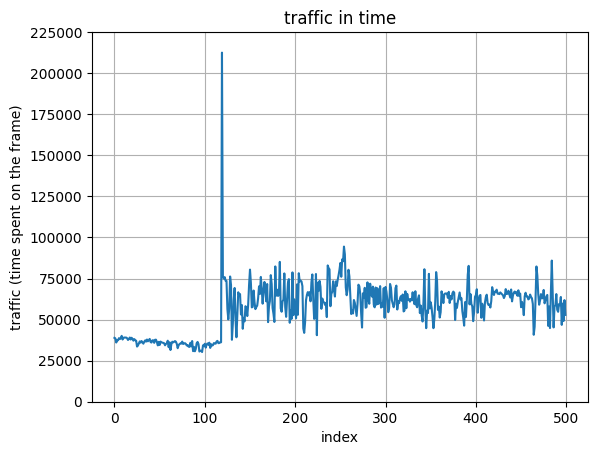

In [ ]:
# displaying the results
m=500
plt.plot(range(m), Y_training[:m] * avg_size)
plt.xlabel('index')
plt.ylabel('traffic (time spent on the frame)')
plt.title('traffic in time')
plt.ylim([0, 225000])
plt.grid()
plt.show()

## 1. **Least Squares linear regression**


Train and evaluate the LS regressor on the data

In [4]:
def least_squares(X_matrix: np.ndarray, labels: np.ndarray) -> None:
    # function that finds the least square solution to linear regression and
    # returns the optimal coefficients
    # creating the matrix A by multiplying X by itself
    A = np.transpose(X_matrix).dot(X_matrix) 
    # creating the vector b by multiplying X by the labels Y
    b = np.transpose(X_matrix).dot(labels)
    # solving the linear system to find the optimal coefficients
    coeff = np.linalg.inv(A).dot(b)
    return coeff

def evaluate_model(x, y, coeff):
    # function that predicts the results for x based on the linear 
    # regression characterized by coeff, and compares such y_pred
    # with the labels y to evaluate the performance of the model
    y_pred = x.dot(coeff)
    mse_vector = (y - y_pred) ** 2
    return np.sum(mse_vector) / len(mse_vector)

In [5]:
# LS training and testing
print('Least Square Linear Regression')
trained_model = least_squares(X_training, Y_training)
print('Training RMSE:', np.sqrt(evaluate_model(X_training, Y_training, trained_model)) * avg_size)
mse = evaluate_model(X_test, Y_test, trained_model)
print('Optimal coefficients:', trained_model)
print('Test RMSE:', np.sqrt(mse) * avg_size)

Least Square Linear Regression
Training RMSE: 9070.165039219852
Optimal coefficients: [0.36986742 0.20348677 0.42565451]
Test RMSE: 7712.3547215391745


## 2. **Least Squares with Tikhonov regularization**

Perform K-fold cross validation with $\lambda\in\{0, 0.1, 1, 10\}$.

In [7]:
def regularized_least_squares(X_matrix: np.ndarray, labels: np.ndarray, lambda_par: np.ndarray) -> None:
    # function that finds the least square solution to linear regression with 
    # Tikhonov regularization and returns the optimal coefficients
    # creating the matrix A by multiplying X by itself
    A = np.transpose(X_matrix).dot(X_matrix)
    # creating the vector b by multiplying X by the labels Y
    b = np.transpose(X_matrix).dot(labels)
    # adding the regularization (diagonal) term in the inverse, and 
    # solving the linear system to find the optima coefficients
    coeff = np.linalg.inv(A + lambda_par * np.eye(np.shape(A)[0])).dot(b)
    return coeff

def K_fold(X_training: np.ndarray, Y_training: np.ndarray, lambda_vec: np.ndarray, K: np.ndarray) -> None:
    # function that performs k-fold cross validation on the training data 
    # (X_training, Y_training) for an input K and for given values of the 
    # regularization parameter lambda

    best = -1 # initializing
    best_perf = 1e20
    results = []
    models = []
    max_idx = np.shape(Y_training)[0]

    perm = np.arange(0, np.shape(X_training)[0], 1) # permutating
    rnd.shuffle(perm)
    X_shuffled = np.asarray(X_training[perm, :])
    Y_shuffled = np.asarray(Y_training[perm])

    fold_points = int(np.floor(max_idx / K)) # splitting the training set in K folds
    for lambda_idx in range(len(lambda_vec)): # for every value of lambda
        lambda_perf = 0
        # training and validating are performed for each lambda value
        for test in range(K):
            # training on all folds but one
            x_train_fold = np.concatenate([X_shuffled[: fold_points * test, :], X_shuffled[fold_points * (test + 1) + 1 :, :]])
            y_train_fold = np.concatenate([Y_shuffled[: fold_points * test], Y_shuffled[fold_points * (test + 1) + 1 :]])
            k_model = regularized_least_squares(x_train_fold, y_train_fold, lambda_par[lambda_idx])
            # validating on the remaining fold
            x_validate_fold = X_shuffled[fold_points * test : fold_points * (test + 1) + 1, :]
            y_validate_fold = Y_shuffled[fold_points * test : fold_points * (test + 1) + 1]
            lambda_perf += evaluate_model(x_validate_fold, y_validate_fold, k_model)
        lambda_perf /= K
        results.append(lambda_perf)
        models.append(regularized_least_squares(X_shuffled, Y_shuffled, lambda_par[lambda_idx]))
        if (best_perf > lambda_perf): # if better results are found, we update the bests
            best = regularized_least_squares(X_shuffled, Y_shuffled, lambda_par[lambda_idx])
            best_perf = lambda_perf
    return best, best_perf, models, results

Regularized Least Square Linear Regression
Optimal coefficients: [0.36966552 0.20416016 0.42515494]


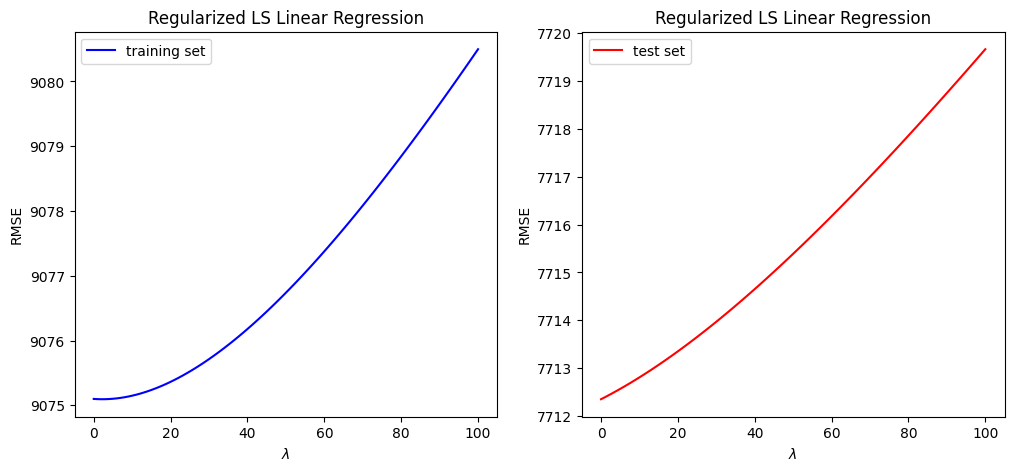

In [17]:
# training and testing the LS linear regression with K-fold cross-validation
K = 5
lambda_par = range(101)
best_model, best_perf, models, results = K_fold(X_training, Y_training, lambda_par, K)
print('Regularized Least Square Linear Regression')
print('Optimal coefficients:', best_model)
test_scores = [evaluate_model(X_test, Y_test, models[i]) for i in range(len(models))]

# plotting the results
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(lambda_par, np.sqrt(results) * avg_size, 'b', label='training set')
ax[0].set_xlabel('$\lambda$')
ax[0].set_ylabel('RMSE')
ax[0].set_title('Regularized LS Linear Regression')
ax[0].legend()
ax[1].plot(lambda_par, np.sqrt(test_scores) * avg_size, 'r', label='test set')
ax[1].set_xlabel('$\lambda$')
ax[1].set_ylabel('RMSE')
ax[1].set_title('Regularized LS Linear Regression')
ax[1].legend()
plt.show()